In [1]:
from TCFile import TCFile

In [1]:
import os
import numpy as np
from TCFile import TCFile

root_dir = "C:/rkka_Projects/cell_death_v2/Data"
folder_list = ['0_Apoptosis', '0_Necroptosis', '0_Necrosis', '0_Control']

tcf_list = []

pathways = dict()
pathways['necroptosis_list'] = []
pathways['apoptosis_list'] = []
pathways['necrosis_list'] = []
pathways['control_list'] = []

for folder in folder_list:
    folder_path = os.path.join(root_dir, folder)
    for p in os.listdir(folder_path):
        if p.endswith('.TCF'):
            tcf_list.append(p)
            if 'Hoechst' in p or 'HeLa_TNF' in p:
                pathways['necroptosis_list'].append(os.path.join(folder, p))
            elif 'CD95' in p:
                pathways['apoptosis_list'].append(os.path.join(folder, p))
            elif 'none' in p or '240820' in p:
                pathways['control_list'].append(os.path.join(folder, p))
            else:
                pathways['necrosis_list'].append(os.path.join(folder, p))

In [19]:
import os
import numpy as np
from TCFile import TCFile

root_dir = "C:/rkka_Projects/cell_death_v2/Data"
folder_list = ['0_Apoptosis', '0_Necroptosis', '0_Necrosis']

tcf_list = []

pathways = dict()
pathways['necroptosis_list'] = []
pathways['apoptosis_list'] = []


for folder in folder_list:
    folder_path = os.path.join(root_dir, folder)
    for p in os.listdir(folder_path):
        if p.endswith('.TCF'):
            tcf_list.append(p)
            if 'Hoechst' in p or 'HeLa_TNF' in p:
                pathways['necroptosis_list'].append(os.path.join(folder, p))
            elif 'CD95' in p:
                pathways['apoptosis_list'].append(os.path.join(folder, p))


In [ ]:
from PIL import Image
from tqdm import tqdm
import cv2
import utils
import torch
from torchvision import models

# configurations
times = [32]
mode = 'mip'
crop_size = (320, 320)
save_path = f'C:/rkka_Projects/cell_death_v2/Data/model_training/blank'
root_dir = 'C:/rkka_Projects/cell_death_v2/Data/'

min, max = 1.33, 1.40

# Crop
for pathway in tqdm(list(pathways.keys())):
    for file_path in pathways[pathway]:    
        try:
            file = TCFile(os.path.join(root_dir, file_path), '3D')
        except:
            print(f'Error occured while opening {os.path.join(root_dir, file_path)}')
        for time_index in times:
            
            slice_2d = utils.resize_tomogram_2d(file[time_index], data_resolution=file.data_resolution,
                                                target_resolution=0.1632, mode='mip')
            
            patches = utils.crop_patch(slice_2d, crop_size=crop_size)
            for patch_index, patch in enumerate(patches):
                top = patch[0]
                left = patch[1]
                cropped = slice_2d[top:top+crop_size[0], left:left+crop_size[1]]
                cropped = utils.image_normalization(cropped, min=min, max=max)  
                # remove bad quality patch
                temp = cropped.copy()
                temp[temp<45] = 0
                temp[temp>=45] = 1
                proportion = np.count_nonzero(temp==1)/(np.count_nonzero(temp==0)+np.count_nonzero(temp==1))
                if pathway != 'necrosis_list':
                    if proportion > 0.05:
                        image = Image.fromarray(cropped)
                        image.save(f"{save_path}/{file_path[:-4]}_patch_{patch_index}_t_{time_index}.png")
                    else:
                        pass
                else:
                    image = Image.fromarray(cropped)
                    image.save(f"{save_path}/{file_path[:-4]}_patch_{patch_index}_t_{time_index}.png")
print('finished!')

 75%|███████▌  | 3/4 [00:32<00:09,  9.98s/it]

Error occured while opening C:/rkka_Projects/cell_death_v2/Data/0_Control\240820.114537.cell death_0820.001.Group1.A1.T001P03.TCF
Error occured while opening C:/rkka_Projects/cell_death_v2/Data/0_Control\241126.155819.hela_none_PP2.001.Group1.A1.T001P01.TCF


 75%|███████▌  | 3/4 [00:49<00:16, 16.48s/it]


AttributeError: 'Dataset' object has no attribute 'keys'

In [7]:
from PIL import Image
from tqdm import tqdm
import cv2
import utils
import torch
from torchvision import models

# configurations
times = [32]
mode = 'mip'
crop_size = (320, 320)
save_path = f'C:/rkka_Projects/cell_death_v2/Data/model_training/blank'
root_dir = 'C:/rkka_Projects/cell_death_v2/Data/'

min, max = 1.33, 1.40

# Crop
for pathway in tqdm(list(pathways.keys())):
    for file_path in pathways[pathway]:    
        try:
            file = TCFile(os.path.join(root_dir, file_path), '3D')
        except:
            print(f'Error occured while opening {os.path.join(root_dir, file_path)}')
        for time_index in times:
            
            slice_2d = utils.resize_tomogram_2d(file[time_index], data_resolution=file.data_resolution,
                                                target_resolution=0.1632, mode='mip')
            
            patches = utils.crop_patch(slice_2d, crop_size=crop_size)
            for patch_index, patch in enumerate(patches):
                top = patch[0]
                left = patch[1]
                cropped = slice_2d[top:top+crop_size[0], left:left+crop_size[1]]
                cropped = utils.image_normalization(cropped, min=min, max=max)  
                # remove bad quality patch
                temp = cropped.copy()
                temp[temp<45] = 0
                temp[temp>=45] = 1
                proportion = np.count_nonzero(temp==1)/(np.count_nonzero(temp==0)+np.count_nonzero(temp==1))
                if pathway != 'necrosis_list':
                    if proportion < 0.02:
                        image = Image.fromarray(cropped)
                        image.save(f"{save_path}/{file_path[-10:]}_patch_{patch_index}_t_{time_index}.png")
                    else:
                        pass
                else:
                    pass
print('finished!')

 75%|███████▌  | 3/4 [00:28<00:08,  8.35s/it]

Error occured while opening C:/rkka_Projects/cell_death_v2/Data/0_Control\240820.114537.cell death_0820.001.Group1.A1.T001P03.TCF
Error occured while opening C:/rkka_Projects/cell_death_v2/Data/0_Control\241126.155819.hela_none_PP2.001.Group1.A1.T001P01.TCF


100%|██████████| 4/4 [00:38<00:00,  9.68s/it]

finished!


<h1> Fluorescence data overlay </h1>

In [3]:
import os
import numpy as np
from TCFile import TCFile

root_dir = "C:/rkka_Projects/cell_death_v2/Data"
folder_list = ['0_Apoptosis', '0_Necroptosis']

tcf_list = []

pathways = dict()
pathways['necroptosis_list'] = []
pathways['apoptosis_list'] = []

for folder in folder_list:
    folder_path = os.path.join(root_dir, folder)
    for p in os.listdir(folder_path):
        if p.endswith('.TCF'):
            tcf_list.append(p)
            if 'Hoechst' in p or 'HeLa_TNF' in p:
                pathways['necroptosis_list'].append(os.path.join(folder, p))
            elif 'CD95' in p:
                pathways['apoptosis_list'].append(os.path.join(folder, p))

In [13]:
from PIL import Image
from tqdm import tqdm
import cv2
import utils
import torch
from torchvision import models

# configurations
times = [32]
mode = 'mip'
crop_size = (320, 320)
save_path = f'C:/rkka_Projects/cell_death_v2/Data/model_training/{mode}/flu/'
root_dir = 'C:/rkka_Projects/cell_death_v2/Data/'

min, max = 1.33, 1.40

# Crop
for pathway in tqdm(list(pathways.keys())):
    for file_path in pathways[pathway]:    
        try:
            file = TCFile(os.path.join(root_dir, file_path), '3D')
            f0 = TCFile(os.path.join(root_dir, file_path), '3DFL', channel=0)
            f1 = TCFile(os.path.join(root_dir, file_path), '3DFL', channel=1)
            f2 = TCFile(os.path.join(root_dir, file_path), '3DFL', channel=2)
        except:
            print(f'Error occured while opening {os.path.join(root_dir, file_path)}')
        for time_index in times:
            
            slice_2d = utils.resize_tomogram_2d(file[time_index], data_resolution=file.data_resolution,
                                                target_resolution=0.1632, mode='mip')
            
            f0_temp = np.max(f0[time_index], axis=0)
            f0_temp = utils.image_normalization(f0_temp, min=np.min(f0_temp), max=np.max(f0_temp))
            
            f1_temp = np.max(f1[time_index], axis=0)
            f1_temp = utils.image_normalization(f1_temp, min=np.min(f1_temp), max=np.max(f1_temp))
            
            f2_temp = np.max(f2[time_index], axis=0)
            f2_temp = utils.image_normalization(f2_temp, min=np.min(f2_temp), max=np.max(f2_temp))
            
            f0_temp = cv2.resize(f0_temp, dsize=slice_2d.shape)
            f1_temp = cv2.resize(f1_temp, dsize=slice_2d.shape)
            f2_temp = cv2.resize(f2_temp, dsize=slice_2d.shape)
            
            patches = utils.crop_patch(slice_2d, crop_size=crop_size)
            for patch_index, patch in enumerate(patches):
                top, left = patch[0], patch[1]
                # Crop the base image and normalize
                cropped = slice_2d[top:top+crop_size[0], left:left+crop_size[1]]
                cropped = utils.image_normalization(cropped, min=min, max=max)

                # Crop the corresponding fluorescence channels
                f0_crop = f0_temp[top:top+crop_size[0], left:left+crop_size[1]]
                f1_crop = f1_temp[top:top+crop_size[0], left:left+crop_size[1]]
                f2_crop = f2_temp[top:top+crop_size[0], left:left+crop_size[1]]

                # Create a fluorescence composite: f2 -> red, f1 -> green, f0 -> blue.
                fluorescence_rgb = np.stack((f2_crop, f1_crop, f0_crop), axis=2).astype(np.uint8)

                # Convert the grayscale base image to RGB
                base_rgb = cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR).astype(np.uint8)

                # Blend the images. Adjust alpha and beta to control overlay transparency.
                alpha = 0.7  # weight for the base image
                beta = 0.3   # weight for the fluorescence overlay
                overlay = cv2.addWeighted(base_rgb, alpha, fluorescence_rgb, beta, 0)

                # (Optional) Quality check on the base image patch remains unchanged.
                temp = cropped.copy()
                temp[temp < 45] = 0
                temp[temp >= 45] = 1
                proportion = np.count_nonzero(temp==1) / (np.count_nonzero(temp==0) + np.count_nonzero(temp==1))
                if pathway != 'necrosis_list':
                    if proportion > 0.1:
                        image = Image.fromarray(overlay)
                        image.save(f"{save_path}/{file_path[:-4]}_patch_{patch_index}_t_{time_index}.png")
                else:
                    image = Image.fromarray(overlay)
                    image.save(f"{save_path}/{file_path[:-4]}_patch_{patch_index}_t_{time_index}.png")
print('finished!')

100%|██████████| 2/2 [02:13<00:00, 66.93s/it]

finished!


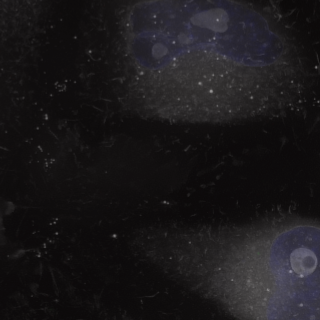

In [11]:
image

In [1]:
from TCFile import TCFile

In [ ]:
from PIL import Image
import utils
from torchvision import models
import os
import numpy as np

# configurations
times = [0]
mode = 'mip'
crop_size = (160, 160)
save_path = f'C:/rkka_Projects/cell_death_v2/Data/Large_FOV/live_png'
root_dir = r"C:\rkka_Projects\cell_death_v2\Data\Large_FOV\train"

min, max = 1.33, 1.40

# Crop

file_list = os.listdir(root_dir)
for file_path in file_list:
    try:
        file = TCFile(os.path.join(root_dir, file_path), '2DMIP')
    except:
        print(1)
    for time_index in times:
        slice_2d = utils.resize_tomogram_mip(file[time_index], data_resolution=file.data_resolution,
                                                target_resolution=0.1632, mode='mip')
            
        patches = utils.crop_patch(slice_2d, crop_size=crop_size)
        for patch_index, patch in enumerate(patches):
            top = patch[0]
            left = patch[1]
            cropped = slice_2d[top:top+crop_size[0], left:left+crop_size[1]]
            cropped = utils.image_normalization(cropped, min=min, max=max)  
            # remove bad quality patch
            temp = cropped.copy()
            temp[temp<45] = 0
            temp[temp>=45] = 1
            proportion = np.count_nonzero(temp==1)/(np.count_nonzero(temp==0)+np.count_nonzero(temp==1))
            if proportion > 0.1:
                image = Image.fromarray(cropped)
                image.save(f"{save_path}/{file_path[:-4]}_patch_{patch_index}_t_{time_index}.png")
            else:
                pass
print('finished!')

1
1
finished!


<h1> Remove All </h1>

In [1]:
import os
root_dir = r"C:\rkka_Projects\cell_death_v2\Data\model_training\mip"
phases = ['train', 'test']
folders = ['0_Apoptosis', '0_Necroptosis', '0_Necrosis', '0_Control']

for p in phases:
    for f in folders:
        path = os.path.join(root_dir, p, f)
        for file in os.listdir(path):
            os.remove(os.path.join(path, file))

<h1> New Cell lines </h1>

In [6]:

from PIL import Image
from TCFile import TCFile
import utils
import os

# configurations
times = [36]
mode = 'mip'
crop_size = (480, 480)
save_path = f'C:/rkka_Projects/cell_death_v2/Data/model_training_HDF/{mode}/data'
root_dir = r"C:\rkka_Projects\cell_death_v2\Data\1_HDF"

min, max = 1.33, 1.40

file_list = os.listdir(r"C:\rkka_Projects\cell_death_v2\Data\1_HDF")

# Crop
for file_path in file_list:

    file = TCFile(os.path.join(root_dir, file_path), '3D')
    for time_index in times:
        slice_2d = utils.resize_tomogram.resize_tomogram_new_cells(file[time_index], data_resolution=file.data_resolution,
                                                target_resolution=0.1632, mode='mip')
            
        patches = utils.crop_patch(slice_2d, crop_size=crop_size)
        for patch_index, patch in enumerate(patches):
            top = patch[0]
            left = patch[1]
            cropped = slice_2d[top:top+crop_size[0], left:left+crop_size[1]]
            cropped = utils.image_normalization(cropped, min=min, max=max)
            
            # remove bad quality patch
            temp = cropped.copy()
            temp[temp<30] = 0
            temp[temp>=30] = 1
            proportion = np.count_nonzero(temp==1)/(np.count_nonzero(temp==0)+np.count_nonzero(temp==1))
            if proportion > 0.1:
                image = Image.fromarray(cropped)
                image.save(f"{save_path}/{file_path[:-4]}_patch_{patch_index}_t_{time_index}.png")
            else:
                pass
print('finished!')

c:\miniconda3\envs\cell\Lib\site-packages\TCFile\TCFile_class.py:190: UserWarning: You use an experimental file format deprecated.
Update your reconstruction program and rebuild TCF file.
  warnings.warn(("You use an experimental file format deprecated.\n"


finished!


<h1> 겹치는거 제거 </h1>

In [23]:
import os

# Directories
reference_folder = "C:/rkka_Projects/cell_death_v2/Data/model_training/mip/train/0_Control"  # Replace with the path to your 2D folder
target_folder = "C:/rkka_Projects/cell_death_v2/Data/model_training/qpi/train/0_Control"  # Replace with the path to your 3D folder

# List filenames in 2D folder (without extensions)
reference_files = {os.path.splitext(file)[0] for file in os.listdir(reference_folder)}

# List files in 3D folder
target_files = os.listdir(target_folder)

# Delete 3D files not in 2D folder
for file in target_files:
    file_name, ext = os.path.splitext(file)  # Split filename and extension
    if file_name not in reference_files:
        file_path = os.path.join(target_folder, file)
        os.remove(file_path)  # Delete the file
        print(f"Deleted: {file_path}")

print("Cleanup completed!")

Deleted: C:/rkka_Projects/cell_death_v2/Data/model_training/qpi/train/0_Control\240820.114537.cell death_0820.001.Group1.A1.T001P01_patch_4_t_34.png
Deleted: C:/rkka_Projects/cell_death_v2/Data/model_training/qpi/train/0_Control\240820.114537.cell death_0820.001.Group1.A1.T001P01_patch_4_t_35.png
Deleted: C:/rkka_Projects/cell_death_v2/Data/model_training/qpi/train/0_Control\240820.114537.cell death_0820.001.Group1.A1.T001P01_patch_4_t_36.png
Deleted: C:/rkka_Projects/cell_death_v2/Data/model_training/qpi/train/0_Control\241126.155819.hela_none_PP2.001.Group1.A1.T001P01_patch_21_t_34.png
Deleted: C:/rkka_Projects/cell_death_v2/Data/model_training/qpi/train/0_Control\241126.155819.hela_none_PP2.001.Group1.A1.T001P01_patch_21_t_35.png
Deleted: C:/rkka_Projects/cell_death_v2/Data/model_training/qpi/train/0_Control\241126.155819.hela_none_PP2.001.Group1.A1.T001P01_patch_21_t_36.png
Deleted: C:/rkka_Projects/cell_death_v2/Data/model_training/qpi/train/0_Control\241126.155819.hela_none_PP2.0

In [22]:
import os

apoptosis_reference = os.listdir(r"C:\rkka_Projects\cell_death_v2\Data\Ground_Truth\0_Apoptosis")
necroptosis_reference = os.listdir(r"C:\rkka_Projects\cell_death_v2\Data\Ground_Truth\0_Necroptosis")

source_path = r"C:\rkka_Projects\cell_death_v2\Data\model_training\mip\train\temp"
destination_path = r"C:\rkka_Projects\cell_death_v2\Data\model_training\mip\train"

source = os.listdir(source_path)

for s in source:
    if s in apoptosis_reference:
        os.rename(os.path.join(source_path, s), os.path.join(destination_path, '0_Apoptosis', s))
        print(f'{s} processed!')
    if s in necroptosis_reference:
        os.rename(os.path.join(source_path, s), os.path.join(destination_path, '0_Necroptosis', s))
        print(f'{s} processed!')

230510.174730.HeLa_Hoechst.001.Group1.A2.T001P02_patch_1_t_32.png processed!
230510.174730.HeLa_Hoechst.001.Group1.A2.T001P02_patch_4_t_32.png processed!
230510.174730.HeLa_Hoechst.001.Group1.A2.T001P02_patch_7_t_32.png processed!
230510.174730.HeLa_Hoechst.001.Group1.A2.T001P03_patch_2_t_32.png processed!
230510.174730.HeLa_Hoechst.001.Group1.A2.T001P03_patch_3_t_32.png processed!
230510.174730.HeLa_Hoechst.001.Group1.A2.T001P03_patch_4_t_32.png processed!
230510.174730.HeLa_Hoechst.001.Group1.A2.T001P03_patch_5_t_32.png processed!
230510.174730.HeLa_Hoechst.001.Group1.A2.T001P03_patch_7_t_32.png processed!
230510.174730.HeLa_Hoechst.001.Group1.A2.T001P17_patch_1_t_32.png processed!
230510.174730.HeLa_Hoechst.001.Group1.A2.T001P17_patch_2_t_32.png processed!
230510.174730.HeLa_Hoechst.001.Group1.A2.T001P17_patch_3_t_32.png processed!
230510.174730.HeLa_Hoechst.001.Group1.A2.T001P17_patch_4_t_32.png processed!
230510.174730.HeLa_Hoechst.001.Group1.A2.T001P17_patch_5_t_32.png processed!

<h1> Large FOV </h1>

In [1]:
from TCFile import TCFile

In [3]:
path = r"C:\rkka_Projects\cell_death_v2\Data\Large_FOV\train\240808.200653.death_B4C4B5.005.Group1.B4.T001P01.TCF"
file = TCFile(path, '2DMIP')
file.data_resolution

[0.15543286502361298, 0.15543286502361298]

In [2]:
from PIL import Image
import cv2
import utils
import os
from tqdm import tqdm
import numpy as np

# configurations
times = [0]
crop_size = (320, 320)
save_path = r"C:\rkka_Projects\cell_death_v2\Data\Large_FOV\live_png"
root_dir = r"C:\rkka_Projects\cell_death_v2\Data\Large_FOV\train"

file_list = ["240808.200653.death_B4C4B5.005.Group1.B4.T001P01.TCF"]

# Crop
for file_path in tqdm(file_list):
    file = TCFile(os.path.join(root_dir, file_path), '2DMIP')
    for time_index in times:
        slice_2d = file[time_index]        
        fy = file.data_resolution[0]/0.1632
        fx = file.data_resolution[1]/0.1632
        
        if fx!=1 and fy!=1:
            slice_2d = cv2.resize(slice_2d, dsize=(1+int(slice_2d.shape[0]*fy), 1+int(slice_2d.shape[0]*fx)))

        patches = utils.crop_patch(slice_2d, crop_size=crop_size)
        for patch_index, patch in enumerate(patches):
            top = patch[0]
            left = patch[1]
            cropped = slice_2d[top:top+crop_size[0], left:left+crop_size[1]]
            cropped = utils.image_normalization(cropped, min=1.33, max=1.40)
            
            # remove bad quality patch
            temp = cropped.copy()
            temp[temp<45] = 0
            temp[temp>=45] = 1
            proportion = np.count_nonzero(temp==1)/(np.count_nonzero(temp==0)+np.count_nonzero(temp==1))
            if proportion > 0.1:
                image = Image.fromarray(cropped)
                image.save(f"{save_path}/{file_path[:-4]}_patch_{patch_index}_t_{time_index}.png")
            else:
                pass
            
print('finished!')

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

finished!
